<a href="https://colab.research.google.com/github/Bornona/Bornona.github.io/blob/main/Bangla_Hate_Comment_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library & Package Import

In [ ]:
! pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 5.3 MB/s 


In [ ]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
import h5py
import csv
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# Predefined Functions

In [ ]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)

    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

# Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import re
import matplotlib.pyplot as plt
path ='/content/drive/My Drive/'

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/FINAL.csv',encoding='UTF-8')
#df = df.drop(columns=['Like', 'Love', 'Haha'])
df.tail()

,Comment,Post,Like,Love,Haha,Hate
1996,আমাদের যাদের সামর্থ্য নেই তাদের অনেক সমস্যা হয়...,মাওয়া ফেরী ঘাটে ইলিশ দিয়ে গরম ভাত | ফারিয়া ও ...,0.0,0.0,0.0,0
1997,মাওয়া ঘাটের ইলিশ মাছ আর লেজ ভর্তার ভিডিও দেখতে...,মাওয়া ফেরী ঘাটে ইলিশ দিয়ে গরম ভাত | ফারিয়া ও ...,0.0,0.0,0.0,0
1998,মহিলাটা অনেক বেশি কথা বলে।,মাওয়া ফেরী ঘাটে ইলিশ দিয়ে গরম ভাত | ফারিয়া ও ...,0.0,0.0,0.0,1
1999,আপা আপনার কথা শুনতেই ভালো লাগে আপনার কন্ঠ শুনল...,মাওয়া ফেরী ঘাটে ইলিশ দিয়ে গরম ভাত | ফারিয়া ও ...,0.0,0.0,0.0,0
2000,আপনি বিলাসিতা করেন অন্য কারোর খারাপ লাগে কারণ ...,মাওয়া ফেরী ঘাটে ইলিশ দিয়ে গরম ভাত | ফারিয়া ও ...,0.0,0.0,0.0,0


Visualize the ratio of Hate comment and No Hate comment

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


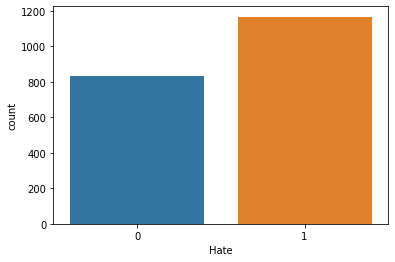

In [ ]:
sns.countplot(df['Hate']);


In [ ]:
(df['Hate'].count())

2001

# Data Preprocessing

In [ ]:
df['Comment'] = df.Comment.apply(lambda x: preprocessing(str(x)))
df['Post'] = df.Post.apply(lambda x: preprocessing(str(x)))
df.reset_index(drop=True, inplace=True)

Prepare the Dataset

In [ ]:
train1, test1 = train_test_split(df,random_state=69, test_size=0.2)
training_sentences = []
testing_sentences = []


train_sentences_comment=train1['Comment'].values
train_sentences_post=train1['Post'].values
train_labels=train1['Hate'].values
for i in range(train_sentences_comment.shape[0]):
    x=str(train_sentences_comment[i])+str(train_sentences_post[i])
    training_sentences.append(x)

training_sentences=np.array(training_sentences)


test_sentences_comment=test1['Comment'].values
test_sentences_post=test1['Post'].values
test_labels=test1['Hate'].values

for i in range(test_sentences_comment.shape[0]):
    x=str(test_sentences_comment[i])+str(test_sentences_post[i])
    testing_sentences.append(x)

testing_sentences=np.array(testing_sentences)


train_labels=keras.utils.np_utils.to_categorical(train_labels)
test_labels=keras.utils.np_utils.to_categorical(test_labels)

print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_sentences.shape))
print("testing_sentences shape: "+str(testing_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))

Training Set Length: 1600
Testing Set Length: 401
training_sentences shape: (1600,)
testing_sentences shape: (401,)
train_labels shape: (1600, 2)
test_labels shape: (401, 2)


The Processed result is here what you see:

In [ ]:
print(training_sentences[10])
print(train_labels[10])

প্রান ভিক্ষার যেনো প্রশ্নই না আসেআসামীদের যেন কখনও প্রাণভিক্ষা দেয়া না হয়

বুয়েট ছাত্র আবরার ফাহাদ হত্যা মামলার রায়ে  জনের মৃত্যুদণ্ড ও  জনকে যাবজ্জীবন কারাদণ্ডের আদেশ দিয়েছেন আদালত ঢাকার এক নম্বর দ্রুত বিচার ট্রাইব্যুনালের বিচারক আবু জাফর মোহাম্মদ কামরুজ্জামান রায় ঘোষণা করেন এ সময় তিনি বলেন বুয়েটের মতো শিক্ষা প্রতিষ্ঠানে এমন নির্মমতা কলঙ্কজনক ঘটনা রায়ে আবরার ফাহাদের বাবা ও মা সন্তোষ প্রকাশ করলেও ন্যায় বিচার না পাওয়ার অভিযোগ করেছে আসামীপক্ষ আবরার ফাহাদের মা বলেন দ্রুতই যেন এই রায় কার্যকর করা হয় এবং আসামীদের যেন কখনও প্রাণভিক্ষা দেয়া না হয়  সালের ই অক্টোবর রাতে বুয়েটের শেরে বাংলা হলের আবাসিক ছাত্র আবরার ফাহাদকে পিটিয়ে হত্যা করে বুয়েটেরই কয়েকজন ছাত্র মামলার রায় ঘোষণার দিন সকালে আটক  আসামিকে কারাগার থেকে আদালতে হাজির করা হয় তাদের উপস্থিতিতে জনাকীর্ণ আদালতে রায় ঘোষণা করেন বিচারক হত্যাকান্ডের  বছর পর এমন নজিরবিহীন রায় দেখলো দেশবাসী
[1. 0.]


Predefine some variables

In [ ]:
vocab_size = 25000
embedding_dim = 300
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"
epochSize = 8
batchSize = 256

In [ ]:
print(training_sentences.shape)
print(train_labels.shape)

(1600,)
(1600, 2)


At first i will tokenize and then i will be padding the sequences.I have used tokenizer only on training dataset to see how the model performs on unseen words

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

11417
Word index length:11417


In [ ]:
print("Sentence :--> \n")
print(training_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

আধা মেয়ে হয়ে যেভাবে সবাইকে পাগল করছো 🥴
পুরো মেয়ে হলে তোশরীরের যত্ন নিতে শিখুন ফলন এমনিতেই আসবে

Sentence Tokenized and Converted into Sequence :--> 

[5558, 2641, 927, 2039, 977, 1772, 5559, 4363, 267, 2641, 76, 5560, 1607, 149, 2307, 2642, 2308, 823]

After Padding the Sequence with padding length 100 :--> 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 5558 2641
  927 2039  977 1772 5559 4363  267 2641   76 5560 1607  149 2307 2642
 2308  823]


In [ ]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (1600, 100)
Padded shape(testing): (401, 100)


Model Creation

At first i have created embeddings from the text.

In first layer,i created an conv1D with 200 as filter for CNN.

In second & third layer,i have applied two Bi-LSTM with a dropout of .5.

In rest of the layer i have applied Dense network.

I have used Adap Optimizer with fine tuned hyperparameters.

I have also applied L2 regularizations to reduce overfitting as much as possible.

Model 1: CNN

In [ ]:
with tf.device('/gpu:0'):
    model1 = Sequential()
    model1.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model1.add(Conv1D(200, kernel_size=3, activation = "relu"))
    model1.add(Dense(50, activation='relu'))
    model1.add(Dense(50, activation='relu'))
    model1.add(Flatten())
    #l2 regularizer
    model1.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
    model1.add(Dense(2, activation='softmax'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
    adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    model1.summary()
    model1.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          7500000   
                                                                 
 conv1d (Conv1D)             (None, 98, 200)           180200    
                                                                 
 dense (Dense)               (None, 98, 50)            10050     
                                                                 
 dense_1 (Dense)             (None, 98, 50)            2550      
                                                                 
 flatten (Flatten)           (None, 4900)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               490100    
                                                                 
 dense_3 (Dense)             (None, 2)                 2

Model 2: LSTM

In [ ]:
with tf.device('/gpu:0'):
    model2 = Sequential()
    model2.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model2.add(Bidirectional(LSTM(64, return_sequences=True)))
    model2.add(Dropout(0.5))
    model2.add(Bidirectional(LSTM(64)))
    model2.add(Dense(50, activation='relu'))
    model2.add(Dense(50, activation='relu'))
    model2.add(Flatten())

    #l2 regularizer
    model2.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
    model2.add(Dense(2, activation='softmax'))

    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
    adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    model2.summary()
    model2.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          7500000   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         186880    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 50)                6450      
                                                                 
 dense_5 (Dense)             (None, 50)               

Model 3: CNN+LSTM

In [ ]:
with tf.device('/gpu:0'):
    model3= Sequential()
    model3.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model3.add(Conv1D(200, kernel_size=3, activation = "relu"))
    model3.add(Bidirectional(LSTM(64, return_sequences=True)))
    model3.add(Dropout(0.5))
    model3.add(Bidirectional(LSTM(64)))
    model3.add(Dense(50, activation='relu'))
    model3.add(Dense(50, activation='relu'))
    model3.add(Flatten())
    #l2 regularizer
    model3.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
    model3.add(Dense(2, activation='softmax'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
    adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    model3.summary()
    model3.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 300)          7500000   
                                                                 
 conv1d_8 (Conv1D)           (None, 98, 200)           180200    
                                                                 
 bidirectional_10 (Bidirecti  (None, 98, 128)          135680    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 98, 128)           0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dense_44 (Dense)            (None, 50)              

trained the model for 5 epochs with batch size 256.

In [ ]:
history1 = model1.fit(padded, train_labels, epochs=5, batch_size=batchSize, validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)
history2 = model2.fit(padded, train_labels, epochs=5, batch_size=batchSize, validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8, verbose = 2,validation_split=0.1)
history3 = model3.fit(padded, train_labels, epochs=5, batch_size=batchSize, validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

Epoch 1/5
7/7 [==============================] - 6s 764ms/step - loss: 2.4274 - accuracy: 0.5763 - val_loss: 2.1008 - val_accuracy: 0.6272
Epoch 2/5
7/7 [==============================] - 5s 724ms/step - loss: 1.9280 - accuracy: 0.7327 - val_loss: 1.6859 - val_accuracy: 0.6574
Epoch 3/5
7/7 [==============================] - 5s 718ms/step - loss: 1.5151 - accuracy: 0.6992 - val_loss: 1.3519 - val_accuracy: 0.7128
Epoch 4/5
7/7 [==============================] - 5s 721ms/step - loss: 1.1491 - accuracy: 0.8588 - val_loss: 1.0717 - val_accuracy: 0.7985
Epoch 5/5
7/7 [==============================] - 5s 723ms/step - loss: 0.8395 - accuracy: 0.8884 - val_loss: 0.9070 - val_accuracy: 0.8136
Epoch 1/5
6/6 - 20s - loss: 1.3452 - accuracy: 0.5690 - val_loss: 1.3248 - val_accuracy: 0.5346 - 20s/epoch - 3s/step
Epoch 2/5
6/6 - 9s - loss: 1.3017 - accuracy: 0.5893 - val_loss: 1.2847 - val_accuracy: 0.5346 - 9s/epoch - 2s/step
Epoch 3/5
6/6 - 9s - loss: 1.2436 - accuracy: 0.5943 - val_loss: 1.2113

# Visualization

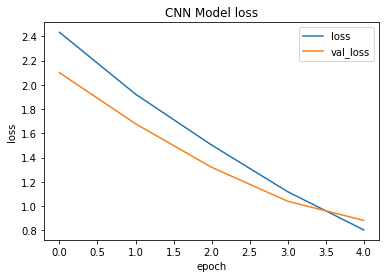

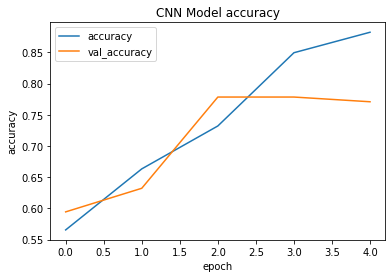

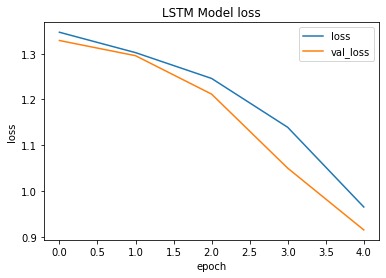

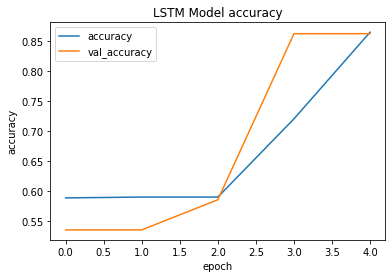

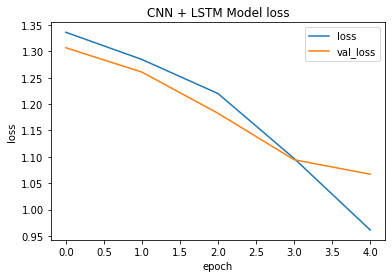

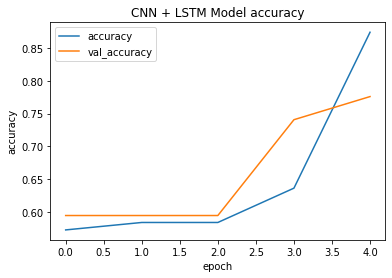

In [ ]:
#plotting loss for CNN
loss = history1.history['loss']
val_loss = history1.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('CNN Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()
print('\n')
accuracy = history1.history['accuracy']
val_accuracy= history1.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('CNN Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
print('\n')


#plotting loss for Bi-LSTM
loss = history2.history['loss']
val_loss = history2.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('LSTM Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()
print('\n')
accuracy = history2.history['accuracy']
val_accuracy= history2.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('LSTM Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
print('\n')


#plotting loss for CNN+LSTM
loss = history3.history['loss']
val_loss = history3.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('CNN + LSTM Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()
print('\n')
accuracy = history3.history['accuracy']
val_accuracy= history3.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('CNN + LSTM Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

# Accuracy and Evaluation

In [ ]:
#accuracy calculation for CNN
print("---------For CNN---------")
loss_and_metrics = model1.evaluate(padded,train_labels,batch_size=256)
print("Train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model1.evaluate(testing_padded,test_labels,batch_size=256)
print("Test accuracy is: "+str(loss_and_metrics[1]))

#accuracy calculation for LSTM
print("\n---------For CNN---------")
loss_and_metrics = model2.evaluate(padded,train_labels,batch_size=256)
print("Train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model2.evaluate(testing_padded,test_labels,batch_size=256)
print("Test accuracy is: "+str(loss_and_metrics[1]))

#accuracy calculation for CNN+LSTM
print("\n---------For CNN---------")
loss_and_metrics = model3.evaluate(padded,train_labels,batch_size=256)
print("Train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model3.evaluate(testing_padded,test_labels,batch_size=256)
print("Test accuracy is: "+str(loss_and_metrics[1]))

---------For CNN---------
7/7 [==============================] - 1s 165ms/step - loss: 0.6657 - accuracy: 0.9029
Train accuracy is: 0.9029003977775574
2/2 [==============================] - 0s 110ms/step - loss: 0.8814 - accuracy: 0.7708
Test accuracy is: 0.7707808613777161

---------For CNN---------
7/7 [==============================] - 3s 414ms/step - loss: 0.8710 - accuracy: 0.8815
Train accuracy is: 0.881462812423706
2/2 [==============================] - 1s 300ms/step - loss: 1.0210 - accuracy: 0.7657
Test accuracy is: 0.7657430768013

---------For CNN---------
7/7 [==============================] - 4s 491ms/step - loss: 0.8822 - accuracy: 0.8890
Train accuracy is: 0.8890290260314941
2/2 [==============================] - 1s 335ms/step - loss: 1.0670 - accuracy: 0.7758
Test accuracy is: 0.7758186459541321


In [ ]:
#CNN
Y_pred1 = model1.predict(testing_padded)

Y_pred1=np.argmax(Y_pred1, axis=1)
Y_test1=np.argmax(test_labels, axis=1)

labels = ['Non Hate', 'Hate']
print(classification_report(Y_test1, Y_pred1))

pd.DataFrame(confusion_matrix(Y_test1, Y_pred1), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.71      0.74      0.72       161
           1       0.82      0.79      0.80       236

    accuracy                           0.77       397
   macro avg       0.76      0.77      0.76       397
weighted avg       0.77      0.77      0.77       397



,Non Hate,Hate
Non Hate,119,42
Hate,49,187


In [ ]:
#LSTM
Y_pred2 = model2.predict(testing_padded)

Y_pred2=np.argmax(Y_pred2, axis=1)
Y_test2=np.argmax(test_labels, axis=1)

labels = ['Non Hate', 'Hate']
print(classification_report(Y_test2, Y_pred2))

pd.DataFrame(confusion_matrix(Y_test2, Y_pred2), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.69      0.76      0.72       161
           1       0.82      0.77      0.80       236

    accuracy                           0.77       397
   macro avg       0.76      0.76      0.76       397
weighted avg       0.77      0.77      0.77       397



,Non Hate,Hate
Non Hate,122,39
Hate,54,182


In [ ]:
#CNN + LSTM
Y_pred3 = model3.predict(testing_padded)

Y_pred3=np.argmax(Y_pred3, axis=1)
Y_test3=np.argmax(test_labels, axis=1)

labels = ['Non Hate', 'Hate']
print(classification_report(Y_test3, Y_pred3))

pd.DataFrame(confusion_matrix(Y_test3, Y_pred3), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.71      0.75      0.73       161
           1       0.82      0.80      0.81       236

    accuracy                           0.78       397
   macro avg       0.77      0.77      0.77       397
weighted avg       0.78      0.78      0.78       397



,Non Hate,Hate
Non Hate,120,41
Hate,48,188


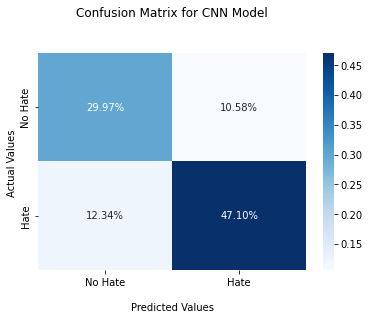

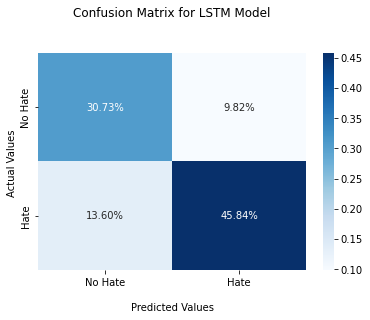

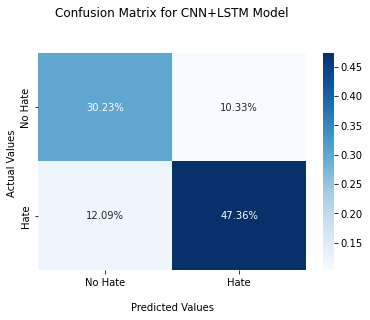

In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(Y_test1, Y_pred1)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for CNN Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['No Hate','Hate'])
ax.yaxis.set_ticklabels(['No Hate','Hate'])

plt.show()
print('\n')

#Generate the confusion matrix
cf_matrix = confusion_matrix(Y_test2, Y_pred2)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for LSTM Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['No Hate','Hate'])
ax.yaxis.set_ticklabels(['No Hate','Hate'])

plt.show()
print('\n')

#Generate the confusion matrix
cf_matrix = confusion_matrix(Y_test3, Y_pred3)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for CNN+LSTM Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['No Hate','Hate'])
ax.yaxis.set_ticklabels(['No Hate','Hate'])

plt.show()

Actual vs Prediction graph

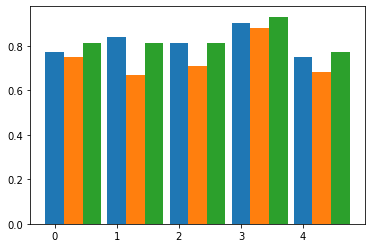

In [ ]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

data1 = [0.77, 0.84, 0.81, 0.90, 0.75]
data2 = [0.75, 0.67, 0.71, 0.88, 0.68]
data3 = [0.81, 0.81, 0.81, 0.93, 0.77]
width = 0.3
plt.bar(np.arange(len(data1)), data1, width=width)
plt.bar(np.arange(len(data2))+ width, data2, width=width)
plt.bar(np.arange(len(data2))+width+ width, data3, width=width)
plt.show()

Text(0, 0.5, 'Score')

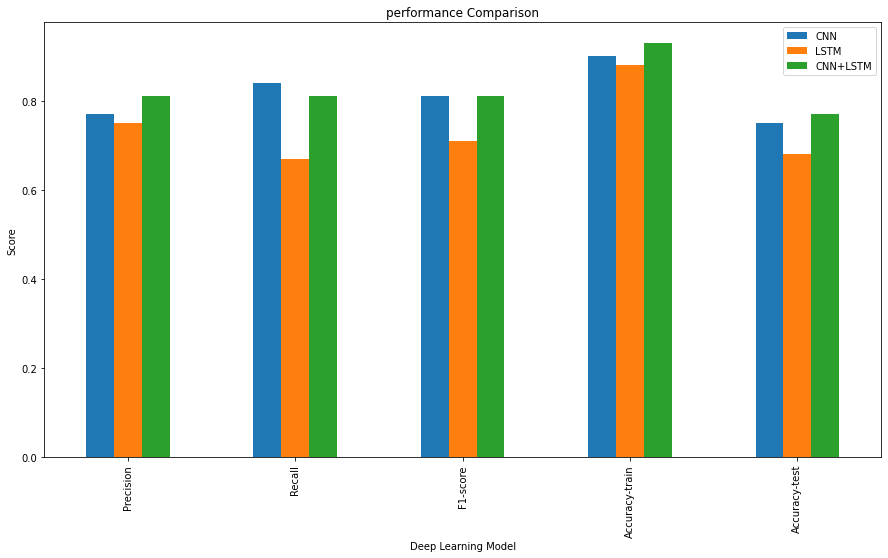

In [ ]:
plotdata = pd.DataFrame({

    "CNN":[0.77, 0.84, 0.81, 0.90, 0.75],

    "LSTM":[0.75, 0.67, 0.71, 0.88, 0.68],

    "CNN+LSTM":[0.81, 0.81, 0.81, 0.93, 0.77]},

    index=["Precision", "Recall", "F1-score", "Accuracy-train", "Accuracy-test"])

plotdata.plot(kind="bar",figsize=(15, 8))

plt.title("performance Comparison")

plt.xlabel("Deep Learning Model")

plt.ylabel("Score")